<h1 style="font-size:200%; font-family:cursive; color:navy;">1. Import Required Libraries & Dataset</h1>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

c:\Users\matia\OneDrive\Escritorio\SignAI-ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check class distribution
df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

<h1 style="font-size:200%; font-family:cursive; color:navy;">2. Split the Dataset into train / test</h1>

In [4]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

<h1 style="font-size:200%; font-family:cursive; color:navy;">3. Import Bert - base- uncased</h1>

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

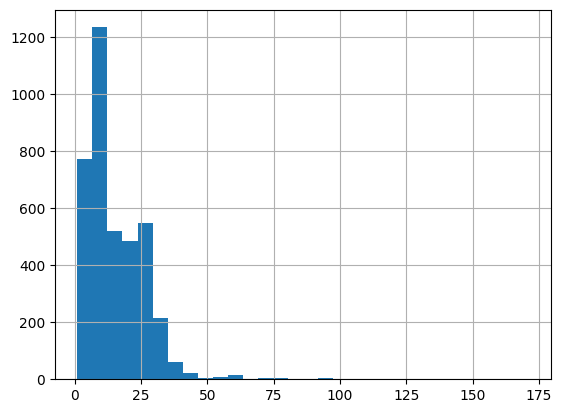

In [6]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

<h1 style="font-size:200%; font-family:cursive; color:navy;">4. Tokenize & Encode the Sequences</h1>

<u><h2 style="font-size:170%; font-family:cursive;">Which Tokenization strategy is used by BERT?</h2></u>

<p style="font-size:150%; font-family:verdana;">BERT uses WordPiece tokenization. The vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added.</p>
<br>
<u><h2 style="font-size:170%; font-family:cursive;">What is the maximum sequence length of the input?</h2></u>

<p style="font-size:150%; font-family:verdana;">The maximum sequence length of the input = 512</p>

In [7]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

c:\Users\matia\OneDrive\Escritorio\SignAI-ML\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<h1 style="font-size:200%; font-family:cursive; color:navy;">5. List to Tensors</h1>

In [8]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

<h1 style="font-size:200%; font-family:cursive; color:navy;">6. Data Loader</h1>

In [9]:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

<h1 style="font-size:200%; font-family:cursive; color:navy;">7. Model Architecture</h1>

In [10]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [11]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        sent_id = torch.tensor([[0] * 512] * 32)
        print(sent_id.shape)  
        mask = torch.tensor([[1] * 512] * 32)
        print(mask.shape)
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [12]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
#model = model.to(device)

In [13]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

c:\Users\matia\OneDrive\Escritorio\SignAI-ML\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:

# number of training epochs
epochs = 10

<h1 style="font-size:200%; font-family:cursive; color:navy;">8. Fine - Tune</h1>

In [15]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [16]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            preds = preds

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [17]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])


KeyboardInterrupt: 

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<h1 style="font-size:200%; font-family:cursive; color:navy;">9. Make Predictions</h1>

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

<center><h1 style="font-size:300%; font-family:cursive; color:black; background:skyblue; padding:15px; border:solid;">REFERENCES & CREDITS</h1></center>

<ol>
    <li style="font-size:150%;"><a href="https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/">How to use BERT in Kaggle competitions - Reddit Thread</a></li>
    <li style="font-size:150%;"><a href="http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">A visual guide to using BERT by Jay Alammar</a></li>
    <li style="font-size:150%;"><a href="https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/">Demystifying BERT: Groundbreaking NLP Framework by Mohd Sanad Zaki Rizvi</a></li>
    <li style="font-size:150%;"><a href="https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03">BERT for Dummies step by step tutorial by Michel Kana</a></li>
</ol>

<br>
<center><h1 style="font-size:300%; font-family:cursive; color:black; background:skyblue; padding:15px; border:solid;">CONCLUSION</h1></center>

<p style="font-size:150%; font-family:verdana;">BERT is undoubtedly a breakthrough in the use of Machine Learning for Natural Language Processing. The fact that it’s approachable and allows fast fine-tuning will likely allow a wide range of practical applications in the future. In this Notebook we have discussed about BERT (Theoritical + Practical Part).</p>

<center><h1 style="font-size:200%; color:green;">Please give this kernel an UPVOTE to show your appreciation, if you find it useful.</h1></center>

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERT_Arch(nn.Module):
    def __init__(self, bert, vocab_size, reduce, max_len=512):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        self.reduce = reduce
        self.vocab_size = vocab_size
        self.max_len = max_len
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # Dense layer (Output layer)
        self.fc = nn.Linear(bert.config.hidden_size, vocab_size)

    def forward(self, seq_input: torch.Tensor):
        # Aplicar reducción de dimensionalidad
        seq_input = seq_input.unsqueeze(1)
        print(seq_input.shape)
        seq_input = self.reduce(seq_input)  # (batch_size, 512)
        print(seq_input.shape)
        # Crear máscara de atención
        attention_mask = torch.ones(seq_input.shape[0], seq_input.shape[1]).to(seq_input.device)

        # Usar el BERT para obtener las representaciones
        outputs = self.bert(inputs_embeds=seq_input, attention_mask=attention_mask, return_dict=True)
        x = outputs.last_hidden_state  # Usar el último estado oculto

        # Pasar por la capa densa
        logits = self.fc(x)  # logits tiene forma (batch_size, 512, vocab_size)

        return logits

    def generate(self, input_ids, max_length=50):
        self.eval()
        generated_tokens = []

        # Inicializar el estado de entrada para generación
        for _ in range(max_length):
            outputs = self.forward(input_ids)
            next_token = torch.argmax(outputs[:, -1, :], dim=-1)  # Obtener el token más probable
            generated_tokens.append(next_token.item())
            
            # Actualizar input_ids para el siguiente token
            input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)

            # Salir si se alcanza el token de fin de secuencia
            if next_token.item() == tokenizer.eos_token_id:
                break
        
        return generated_tokens

# Inicializar el modelo con BERT y vocab_size
model = BERT_Arch(bert, vocab_size, reduce)

# Mover el modelo a la GPU
model = model.to(device)

# Definir el optimizador y la función de pérdida
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)
cross_entropy = nn.CrossEntropyLoss()

# Número de épocas de entrenamiento
epochs = 10
